In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk

import yfinance as yf
import datetime




In [117]:
ticker='KCHOL.IS'
start="2020-06-01"
end=str(datetime.date.today() +datetime.timedelta(days=1))
kchol=yf.download(ticker,start,end)


[*********************100%***********************]  1 of 1 completed


In [118]:
kchol

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-01,16.230000,16.900000,16.230000,16.850000,15.597152,6587518
2020-06-02,16.840000,17.309999,16.820000,17.299999,16.013693,10310413
2020-06-03,17.700001,17.860001,17.549999,17.709999,16.393208,5626163
2020-06-04,17.850000,17.889999,17.459999,17.510000,16.208078,5427441
2020-06-05,17.580000,17.840000,17.290001,17.790001,16.467260,8803472
...,...,...,...,...,...,...
2023-06-12,104.599998,105.500000,101.000000,101.000000,101.000000,22706743
2023-06-14,99.949997,103.599998,98.300003,99.300003,99.300003,32298664
2023-06-15,99.800003,101.099998,98.849998,101.000000,101.000000,25989506


In [119]:
close=pd.DataFrame(kchol["Close"])

close


,Close
Date,
2020-06-01,16.850000
2020-06-02,17.299999
2020-06-03,17.709999
2020-06-04,17.510000
2020-06-05,17.790001
...,...
2023-06-12,101.000000
2023-06-14,99.300003
2023-06-15,101.000000


In [120]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=13).mean()
rolling_app21=close.rolling(window=21).mean()



In [121]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [122]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2020-06-29,17.719999,17.404000,17.275385,17.360476
2020-06-30,18.139999,17.534000,17.367692,17.421905
2020-07-01,17.549999,17.606000,17.396923,17.433810
2020-07-02,17.719999,17.700000,17.442308,17.434286
2020-07-03,17.510000,17.727999,17.447692,17.434286
...,...,...,...,...
2023-06-12,101.000000,99.739999,87.884616,85.169048
2023-06-14,99.300003,100.820000,89.903847,85.285715
2023-06-15,101.000000,101.020000,91.903847,85.942858


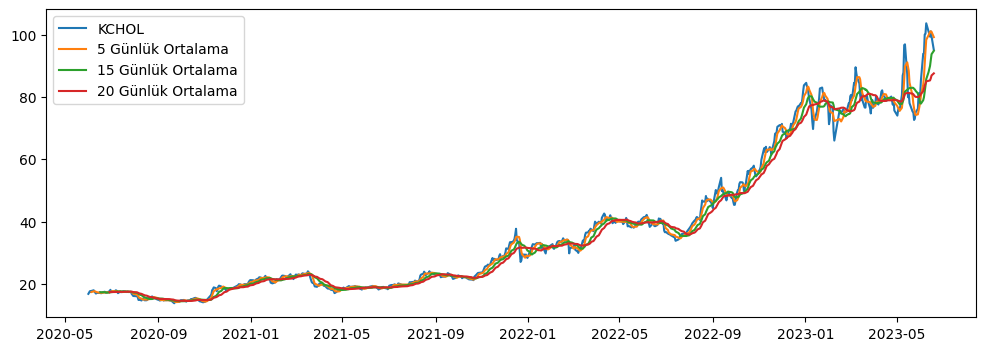

In [123]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='KCHOL')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='15 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='20 Günlük Ortalama')
ax.legend(loc='upper left')


In [124]:
def buy_sell(data,perc=25):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    sm=np.abs(np.percentile(np.array(data["short"]-data["mid"]),perc))
    sl=np.abs(np.percentile(np.array(data["short"]-data["long"]),perc))

    for i in range(0,len(data)):
        if (data["short"][i]>data["mid"][i]+sm) & (data["short"][i]>data["long"][i]+sl):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i]<data["mid"][i]-sm)&(data["short"][i]<data["long"][i]-sl):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    operations=operations[neg:-pos]
    PL=np.sum(operations)

    return (buy_signal,sell_signal,PL)


In [125]:
m=buy_sell(MAs)
MAs["Al"]=m[0]
MAs["Sat"]=m[1]

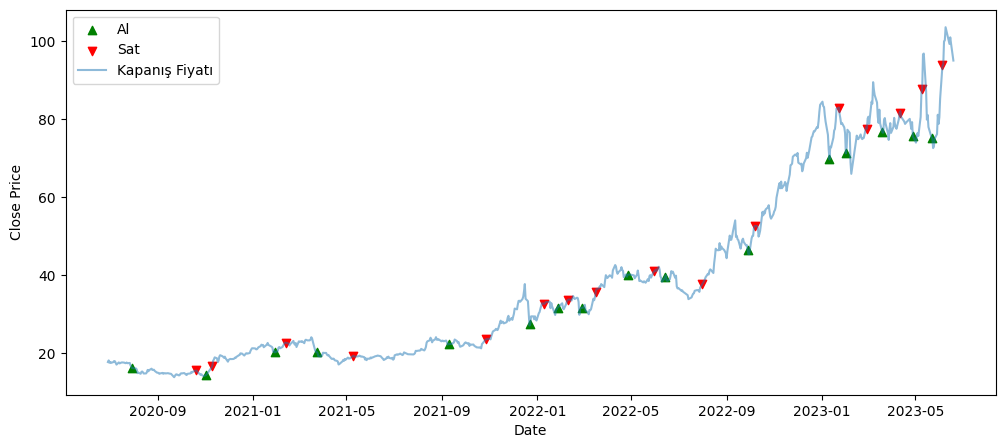

In [126]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Al"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sat"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [127]:
al=MAs["Al"]
al=al.dropna(axis=0)
al

Date
2020-07-30    16.170000
2020-11-02    14.380000
2021-01-29    20.200001
2021-03-24    20.320000
2021-09-10    22.340000
2021-12-23    27.540001
2022-01-27    31.700001
2022-02-28    31.639999
2022-04-28    40.139999
2022-06-14    39.540001
2022-09-28    46.419998
2023-01-11    69.699997
2023-02-01    71.250000
2023-03-20    76.599998
2023-04-28    75.650002
2023-05-22    75.300003
Name: Al, dtype: float64

In [128]:
sat=MAs["Sat"]
sat=sat.dropna(axis=0)
sat


Date
2020-10-20    15.570000
2020-11-10    16.780001
2021-02-12    22.700001
2021-05-10    19.350000
2021-10-27    23.559999
2022-01-10    32.639999
2022-02-10    33.720001
2022-03-17    35.779999
2022-05-31    40.980000
2022-08-01    37.759998
2022-10-07    52.650002
2023-01-23    83.000000
2023-02-28    77.550003
2023-04-11    81.699997
2023-05-10    87.849998
2023-06-05    93.800003
Name: Sat, dtype: float64

In [82]:
del sat["2021-03-05"]

In [129]:
sat_val=sat.values
al_val=al.values


In [130]:
sat_val1=sat_val

In [131]:
sat_val1

array([15.56999969, 16.78000069, 22.70000076, 19.35000038, 23.55999947,
       32.63999939, 33.72000122, 35.77999878, 40.97999954, 37.75999832,
       52.65000153, 83.        , 77.55000305, 81.69999695, 87.84999847,
       93.80000305])

In [132]:
al_val1=al_val
al_val1

array([16.17000008, 14.38000011, 20.20000076, 20.31999969, 22.34000015,
       27.54000092, 31.70000076, 31.63999939, 40.13999939, 39.54000092,
       46.41999817, 69.69999695, 71.25      , 76.59999847, 75.65000153,
       75.30000305])

In [133]:
res=[]

for i in range(len(al_val1)):
    res.append((sat_val1[i]/al_val1[i]))

In [134]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,0.962894
1,1.166899
2,1.123762
3,0.952264
4,1.054611
5,1.185185
6,1.063722
7,1.130847
8,1.020927
9,0.954982


In [135]:
res0=[100]
for i in range(16):
    res0.append(res0[i]*df["Kar"].loc[i])


In [136]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,0.962894,96.289423
1,1.166899,112.359984
2,1.123762,126.265922
3,0.952264,120.238468
4,1.054611,126.804755
5,1.185185,150.287109
6,1.063722,159.863766
7,1.130847,180.781462
8,1.020927,184.564632
9,0.954982,176.255944


In [137]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 299.77283578793737


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [138]:
sat_val2=sat_val[1:16:2]

In [139]:
sat_val2

array([16.78000069, 19.35000038, 32.63999939, 35.77999878, 37.75999832,
       83.        , 81.69999695, 93.80000305])

In [140]:
al_val2=al_val[0:16:2]
al_val2

array([16.17000008, 20.20000076, 22.34000015, 31.70000076, 40.13999939,
       46.41999817, 71.25      , 75.65000153])

In [141]:
res1=[]

for i in range(7):
    res1.append((sat_val2[i]/al_val2[i]))

In [142]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,1.037724
1,0.957921
2,1.461056
3,1.128707
4,0.940707
5,1.788022
6,1.146667


In [143]:
res2=[100]
for i in range(7):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [144]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,1.037724,103.772422
1,0.957921,99.405759
2,1.461056,145.237416
3,1.128707,163.930424
4,0.940707,154.210579
5,1.788022,275.731981
6,1.146667,316.172660


In [145]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 216.1726600763178
